## Microbe Vision (ver 0.1.1) -  Walkthrough
Last updated: 08-Aug-2024

### Introduction
Microbe Vision is a comprehensive package designed to track and analyze the movement of microorganisms in video files or image sequences. This package provides tools for loading, identifying, tracking, and analyzing the movement of various organisms.

#### Features
- Capture: Load video files or image sequences and convert them into frames.
- Identify: Detect and identify microorganisms using thresholding or advanced Omnipose masking.
- Tracker: Track identified organisms across frames, applying filters to retain meaningful tracks.
- Stats: Analyze tracked organisms to calculate speed, movement patterns, and other metrics.

### Walkthrough

This notebook provides an in-depth guide to understanding and working through all the steps needed to properly use the package. In this walkthrough, a user will get a clear view of how to set up, configure, and run the package according to needs.

We will use an example video throughout the notebook to illustrate the process. This example will enable us to convey practical insight and further realize the functionalities offered by the package. Be it the first time, or you want to go deeper, this walkthrough will help you through all the steps to make everything as smooth and efficient as possible.

At the bottom of the notebook, we briefly survey the more advanced features of Trackpy. To delve deeper, please explore the [rest of the documentation](https://github.com/indraneel207/microbe_vision) for additional information

### Installation Instructions

To install this Python-based package, please use the pip installer. Below are the necessary commands to execute prior to usage.

**Important:** Ensure that Python version 3.10.11 is installed, as it is required for this package to function correctly.

1. First, install the package:

In [ ]:
%pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple microbe-vision

2. Additionally, this package relies on another package, Omnipose. To ensure compatibility with our use case, you must install a specific version of Omnipose using a custom commit, as the hosted version does not meet our requirements. Please execute the following command to install the appropriate version.

In [ ]:
%pip install git+https://github.com/kevinjohncutler/omnipose.git@63045b1af0d52174dee7ff18e

Once the installation is complete, you are fully prepared to use this package.

### Demonstration

Let's proceed with the demonstration. For this purpose, we have selected a sample video to illustrate the process.

#### Loading Libraries
To begin, let's load all the necessary libraries into the notebook.

In [3]:
# Importing all the necessary modules from the package
from microbe_vision.capture import Capture
from microbe_vision.identify import Identify
from microbe_vision.stats import Stats
from microbe_vision.track import Tracker

# Importing all the necessary constants
from microbe_vision.constants import AvailableOperations, AvailableProps, PropsThreshold 

# Matplotlib settings for better visualization
%matplotlib inline

#### Step 1: Capture

This class is responsible for ingesting video or image frames and preparing them for subsequent processing by other classes. Before proceeding, ensure that you have a designated working directory. If no directory is specified, the package will automatically create a folder named 'input_files'. 

Once the directory is ready, you can specify its path when creating the 'capture' object, as demonstrated below.

In [4]:
# Initialize the capture object
# This makes a directory called 'input_files' in the current working directory
capture = Capture()

For an existing directory, you can pass the path to the directory as an argument
```python
capture = Capture('PATH_TO_FOLDER')
```

Once the directory is specified, it will serve as the working directory for the entire process, and all output files will be stored in this same folder.

Next, you can proceed by providing the video file name to the function, which will verify whether the file exists. The function supports various video formats as input, including:

- AVI
- MP4
- MPEG
- MKV
- and others.

Additionally, as an added benefit, the function can display key video information such as duration, dimensions, frame rate, and more.

In [5]:
# Capture from video
capture.load_video('sample.avi')

---------- Video Stats ----------
Video Frame Width: 1440
Video Frame Height: 1080
Frame Rate: 15.0 FPS
Total Frames: 1509.0 frames
Video Duration (s): 100.6
---------------------------------
Video file loaded successfully: input_files/sample.avi


'input_files/sample.avi'

Once the file is verified, you can proceed to retrieve the frames. If necessary, these frames can also be stored in the specified directory. Additionally, you must provide certain parameters to the function, including frame rate, pixel scale factor, and scale units.

- The frame rate parameter is primarily used for statistical calculations and defaults to the actual video frame rate, which is 15 in this example. 
- The pixel scale factor is the conversion ratio from a pixel to a specific unit in which the video was recorded (e.g., micrometer, centimeter). 
- The scale units parameter specifies the unit as a string, ensuring accurate measurement and analysis.

In [6]:
# Process video into frames and store them in a directory named 'frames'
frames = capture.process_video_into_frames(pixel_scale_factor=0.166666, scale_units='um', is_store_video_frames=True, store_images_path='frames')

Frame capture progress: 100%|██████████| 1509/1509 [01:25<00:00, 17.74it/s]

1509 frame(s) captured successfully for the video FPS: 15.0 to the folder: input_files/frames
Processed video into frames successfully with pixel scale factor: 0.166666 um


##### Alternatively - Load images as frames
Alternatively, you can load the actual frames using the function shown below(instead of load and process). In this example, "frames" is the folder name where the frames are stored inside the main directory you provided. For instance, the path could be `input_files/frames/frame1.tiff`.

```python
capture.load_images_as_frames('frames', capture_speed_in_fps=15, pixel_scale_factor=0.166666, scale_units='um')
```

This function allows you to specify the folder containing the frames, along with parameters such as the capture speed in frames per second (FPS) and the pixel scale factor, scale units as above.

#### Step 2: Identify

In this step, we apply various methods to identify different items present in each of the frames loaded earlier. To initiate the `Identify` class, you must input the previously created `Capture` object. This object serves as the foundation for identifying and analyzing the elements within the frames.



In [7]:
# Initialize the identify object with the capture object
identify = Identify(capture_frame_object=capture)

After each function execution, you can use a visualization function to view the modified frames. This allows you to observe the changes and identifications made during the process, providing a clear understanding of how the data is being processed and which elements have been identified. You can specify the number of frames you wish to view, which will be selected from the stack at equidistant intervals. 

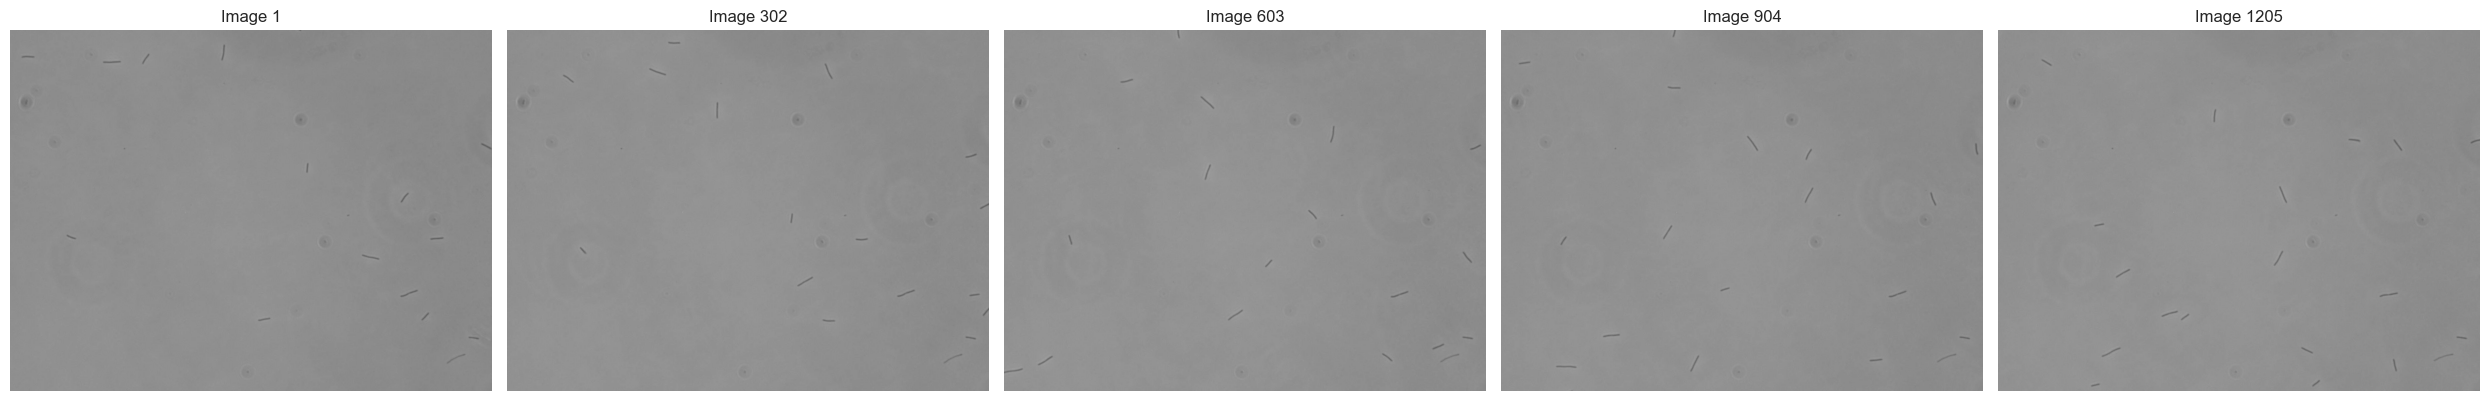

In [8]:
# Display the original frames
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

Let's apply some grayscale thresholding to enhance the visibility of the microorganisms within the frames. This process will help to distinguish the organisms more clearly by adjusting the pixel intensity values. Please note that the thresholding value must be between 0 and 1. Once the thresholding is applied, you can visualize the frames to observe the differences and see how the organisms stand out more prominently.

Applying grayscale thresholding: 100%|██████████| 1509/1509 [00:17<00:00, 85.67it/s]


Threshold applied successfully.


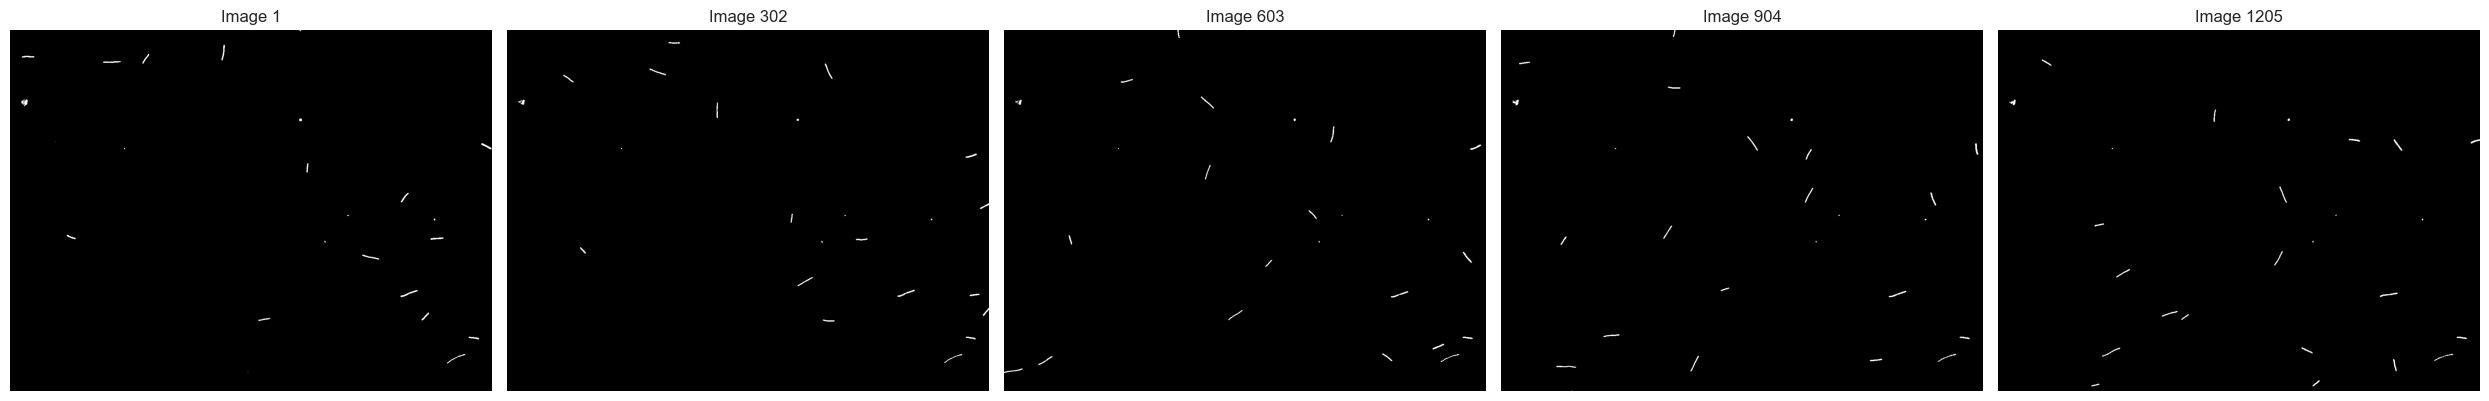

In [9]:
# Apply grayscale thresholding
identify.apply_grayscale_thresholding(threshold=0.52, is_update_frames=True)
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

**Tip:** You can try adjusting the threshold values to achieve better results. Fine-tuning this parameter can significantly improve the clarity of the microorganisms in the frames.

##### Omnipose Masking
Now, it's time to use more advanced tools. We can create another object and enhance the results further by utilizing the Omnipose package. Before proceeding, you must initialize the model and configure the GPU settings to optimize performance and accuracy. For more details on Omnipose models, you can refer to the [Omnipose documentation](https://omnipose.readthedocs.io/index.html).

In [10]:
identify_omnipose = Identify(capture_frame_object=capture)
identify_omnipose.initialize_omnipose_model(model_name='bact_phase_omni', use_gpu=True)

[distfit] >INFO> ** TORCH GPU version installed and working. **
[distfit] >INFO> >>bact_phase_omni<< model set to be used
[distfit] >INFO> ** TORCH GPU version installed and working. **
[distfit] >INFO> >>>> using GPU


>>> GPU activated? True


Preparing frames for the omnipose model: 100%|██████████| 1509/1509 [00:20<00:00, 73.25it/s]

Frames prepared successfully for the omnipose model.
Omnipose model initialized successfully.


**Note:** To retrieve the available Omnipose models, you can use the following function:

```python
identify.get_possible_omnipose_model_names()
```

This function will provide a list of possible models that you can choose from, allowing you to select the most suitable one for your analysis.

Next, you can proceed to apply the Omnipose library to your frames. Please be aware that this process can take a significant amount of time, depending on the complexity of your video, its duration, and the performance of your device.

In [11]:
# Apply Omnipose model
identify_omnipose.apply_omnipose_masking(batch_size=100, save_masks=True, masks_store_path='masks', is_update_frames=True);

Segmenting images:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 102.82135486602783s


Segmenting images:   6%|▋         | 1/16 [01:43<25:53, 103.59s/it]

Batch 1 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 104.2375648021698s


Segmenting images:  12%|█▎        | 2/16 [03:28<24:22, 104.43s/it]

Batch 2 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 104.75874042510986s


Segmenting images:  19%|█▉        | 3/16 [05:14<22:44, 104.99s/it]

Batch 3 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 107.08527898788452s


Segmenting images:  25%|██▌       | 4/16 [07:02<21:13, 106.12s/it]

Batch 4 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 108.53739190101624s


Segmenting images:  31%|███▏      | 5/16 [08:51<19:40, 107.29s/it]

Batch 5 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 118.02746486663818s


Segmenting images:  38%|███▊      | 6/16 [10:50<18:32, 111.22s/it]

Batch 6 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 126.16509699821472s


Segmenting images:  44%|████▍     | 7/16 [12:57<17:27, 116.39s/it]

Batch 7 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 115.7675449848175s


Segmenting images:  50%|█████     | 8/16 [14:53<15:31, 116.44s/it]

Batch 8 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 117.83034014701843s


Segmenting images:  56%|█████▋    | 9/16 [16:52<13:39, 117.13s/it]

Batch 9 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 124.11115789413452s


Segmenting images:  62%|██████▎   | 10/16 [18:57<11:57, 119.53s/it]

Batch 10 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 128.3684151172638s


Segmenting images:  69%|██████▉   | 11/16 [21:06<10:12, 122.50s/it]

Batch 11 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 108.3863251209259s


Segmenting images:  75%|███████▌  | 12/16 [22:55<07:53, 118.46s/it]

Batch 12 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 128.27567291259766s


Segmenting images:  81%|████████▏ | 13/16 [25:04<06:05, 121.67s/it]

Batch 13 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 163.27551794052124s


Segmenting images:  88%|████████▊ | 14/16 [27:49<04:28, 134.50s/it]

Batch 14 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 148.60003304481506s


Segmenting images:  94%|█████████▍| 15/16 [30:18<02:18, 138.99s/it]

Batch 15 segmentation is complete


  0%|          | 0/9 [00:00<?, ?it/s]

Segmenting images: 100%|██████████| 16/16 [30:32<00:00, 114.51s/it]

total segmentation time: 13.556097030639648s
Batch 16 segmentation is complete
Objects segmented successfully using the omnipose model.


Let's check the output after the Omnipose identification by using the same function to display the frames. This will allow us to visualize the results and see how the microorganisms have been identified and segmented by the Omnipose model.

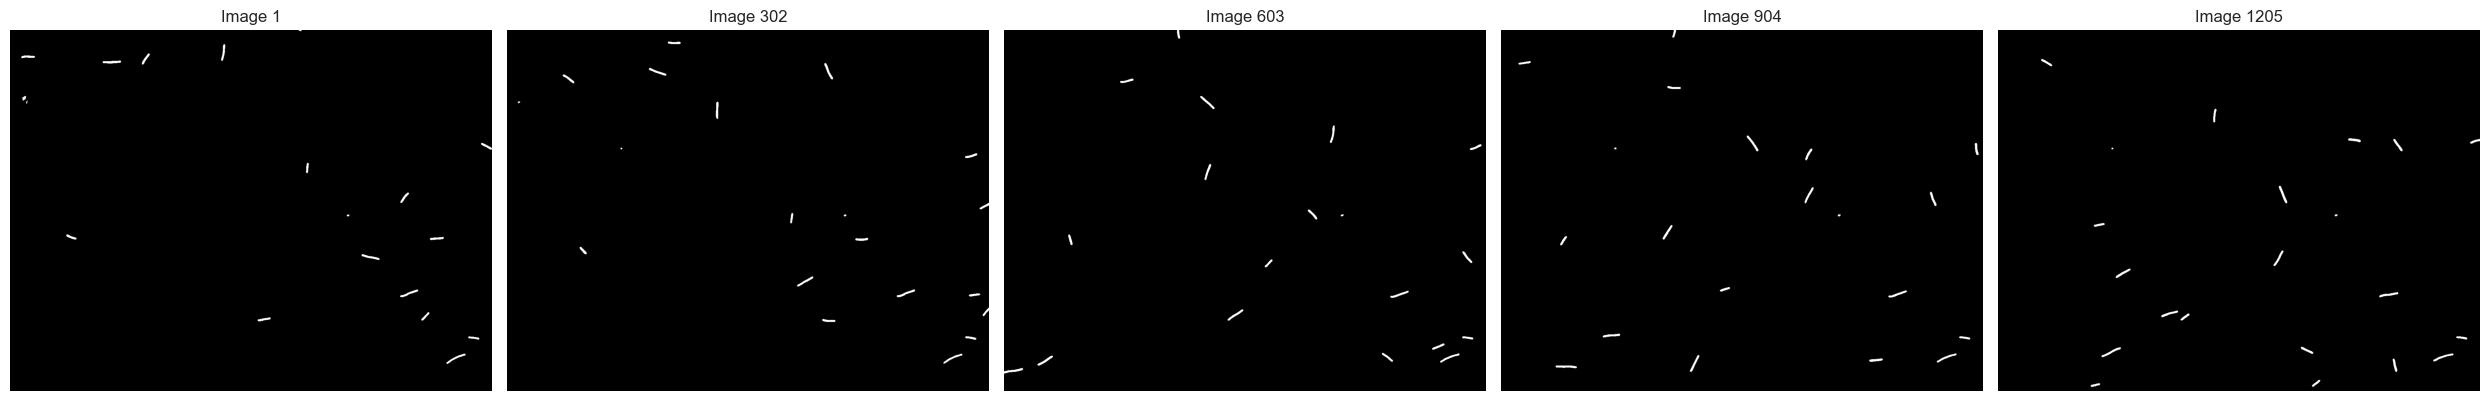

In [12]:
# # Display frames after applying grayscale thresholding
identify_omnipose.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

The next step is to generate region properties for the frames to identify particles and their characteristics, such as:

- AREA
- CENTROID
- MAJOR_AXIS_LENGTH
- MINOR_AXIS_LENGTH

You can create a DataFrame containing these properties using the following code.

In [13]:
# Specify the properties you want to view
view_props = [
    AvailableProps.LABEL,
    AvailableProps.AREA,
    AvailableProps.CENTROID,
    AvailableProps.MAJOR_AXIS_LENGTH,
    AvailableProps.MINOR_AXIS_LENGTH
]

# Generate region properties for the frames and store them in a DataFrame
region_props_df = identify.generate_region_props_to_dataframe(view_props)

# Display the DataFrame
region_props_df

Generating region properties: 100%|██████████| 1509/1509 [00:16<00:00, 93.53it/s]

Region properties generated successfully.


,label,area,centroid_x,centroid_y,major_axis_length,minor_axis_length,frame
0,1,42.0,1.785714,864.571429,12.545019,4.628739,1
1,2,194.0,69.597938,637.139175,53.917969,5.300993,1
2,3,134.0,88.179104,404.947761,39.155241,4.742287,1
3,4,152.0,82.151316,53.552632,42.105641,4.991480,1
4,5,203.0,98.113300,303.571429,59.041581,4.549867,1
...,...,...,...,...,...,...,...
38728,25,104.0,928.894231,446.048077,31.279330,4.385621,1509
38729,26,76.0,972.526316,1346.052632,36.210289,3.264093,1509
38730,27,69.0,983.318841,1314.942029,30.868032,3.324074,1509
38731,28,90.0,1028.666667,394.411111,27.603816,4.334954,1509


This will generate a DataFrame containing the specified region properties for each identified particle in the frames, allowing you to analyze their characteristics in detail.

Please note that you must use the AvailableProps enums when specifying the properties to supply to the function. This ensures that the function correctly interprets the requested properties and generates the appropriate region properties DataFrame. Using `AvailableProps` enums ensures that the correct properties are extracted and included in your analysis.

Now, you can apply multiple filters to the calculated region properties, such as filtering by properties that are less than or greater than a specified value. These filters can be combined using logical 'AND' operations. The implementation is shown below. You can use the `AvailableProps` enums for property values and `AvailableOperations` enums for specifying the operations.

In [14]:
# importing the list module
from typing import List

# Apply filters on region properties
props_threshold: List[PropsThreshold] = [
    {
        'property': AvailableProps.AREA,               # Property to filter on
        'operation': AvailableOperations.GREATER_THAN, # Operation to perform
        'value': 86                                    # Value to compare with
    }
]

# Apply filters on the generated region properties
filtered_df = identify.apply_filters_on_region_props(props_threshold)

Filters applied successfully.


In above implementation, The filter selects regions where the `AREA` is greater than 86.

NOTE: These filters are combined with 'AND', meaning that only regions meeting all specified conditions will be included in the resulting DataFrame.

To finalize the analysis, you can use the `plot_centroids` function to visualize the motility of the biomes. This will allow you to observe how the centroids of the identified objects move across the frames. After that, you can save the results to a CSV file using the `save_identified_objects_to_csv` function for further analysis or record-keeping.

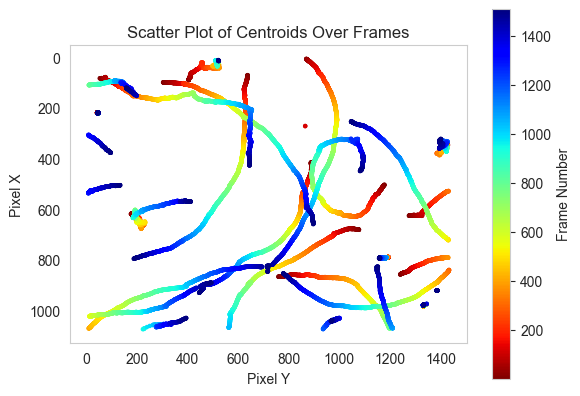

Identified objects saved successfully to path:  input_files/identified_objects.csv


In [15]:
# Plot the filtered region properties
identify.plot_centroids(show_time=True)

# Save identified objects to CSV
identify.save_identified_objects_to_csv(output_file_name='identified_objects')

#### Step 3: Tracking

In this step, we tie the biomes together across the frames to create a trajectory for each one. This process allows us to track the movement of individual biomes over time, forming a continuous path or trajectory for each identified object.

To perform this tracking, you'll need to supply the Identify object, created in the previous steps, to the tracking module. This ensures that the tracking process is based on the objects and properties identified earlier.

In [16]:
tracker = Tracker(identify_object=identify)

To further refine the tracking process, you can link particles across frames and apply filters to ensure that only relevant trajectories are retained. The following code demonstrates how to link particles and filter them based on criteria such as minimum frames and displacement.

In [17]:
# Link particles across frames
tracker.link_particles(max_distance=50, max_memory=50, position_columns=['centroid_x', 'centroid_y'])

# Filter particles to retain only those with a minimum number of frames and displacement
tracker.filter_particles(min_frames=500, min_displacement=10, is_update_particles=True)

Frame 1509: 22 trajectories present.
Successfully linked 30 particles.
After filtering based on min 500 frames: 19 unique particles
After filtering based on min 10 displacement filtering: 16 unique particles


,label,area,centroid_x,centroid_y,major_axis_length,minor_axis_length,frame,particle
frame,,,,,,,,
1,2,194.0,69.597938,637.139175,53.917969,5.300993,1,0
1,21,125.0,865.784000,759.048000,40.172494,4.154439,1,3
1,18,199.0,680.341709,1076.869347,59.893573,4.651201,1,5
1,15,123.0,620.634146,182.211382,32.453525,5.205690,1,7
1,19,239.0,788.870293,1191.359833,62.243474,5.466811,1,8
...,...,...,...,...,...,...,...,...
1509,9,129.0,425.860465,644.651163,42.034263,4.274698,1509,13
1509,6,179.0,321.877095,1400.798883,39.874216,6.174055,1509,10
1509,4,179.0,252.793296,1046.335196,46.586242,5.474212,1509,20


The explanation for the tracking can be as follows:
1. **Linking Particles:**
   - `max_distance=50`: The maximum distance allowed between consecutive particle positions for them to be linked together in a trajectory.
   - `max_memory=50`: The number of frames in which a particle can be "forgotten" and later relinked if it reappears within the allowed distance.
   - `position_columns=['centroid_x', 'centroid_y']`: Specifies the columns representing the x and y coordinates of the centroid for linking purposes.

2. **Filtering Particles:**
   - `min_frames=500`: Filters out particles that appear in fewer than 500 frames.
   - `min_displacement=10`: Filters out particles that have a displacement (movement) less than 10 units, ensuring only significant movements are tracked.
   - `is_update_particles=True`: Updates the particle trajectories based on the filtering criteria, removing those that do not meet the minimum frame and displacement requirements.

To save the results to a CSV file we can do the following:

In [18]:
# Save linked dataframes
tracker.save_linked_dataframes(output_file_name='linked_particles')

Linked dataframes saved to input_files/linked_particles.csv


To visualize the tracks from different perspectives, here are some functions that can help you better understand the movements:
1. Plot trajectories:

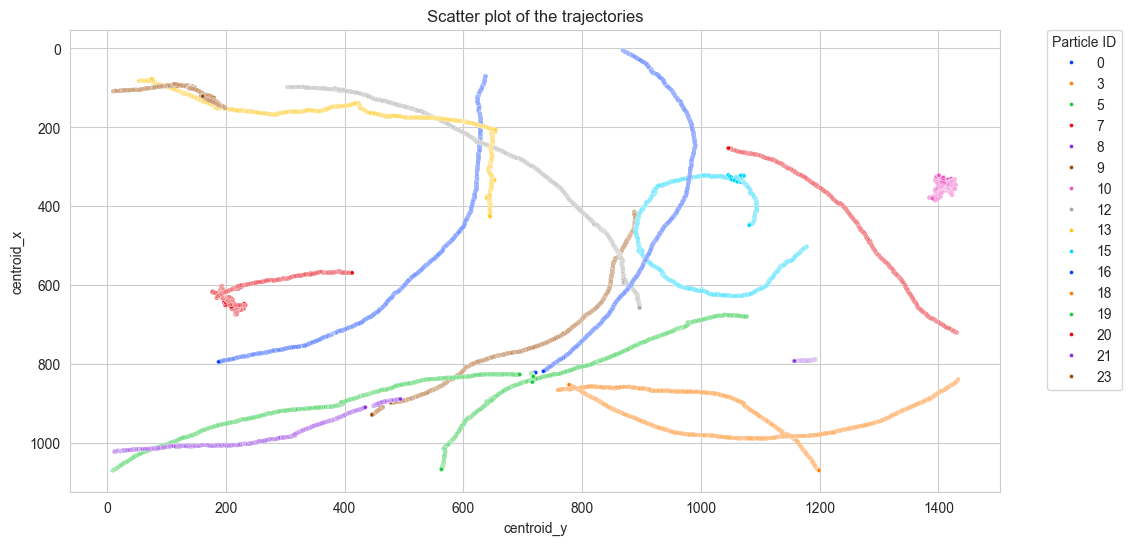

In [19]:
# Plot trajectories using scatter plot
tracker.sort_and_plot_scatter_of_trajectories()

2. Visualize the movements from an origin point perspective to analyze their direction and the distance they have traveled.

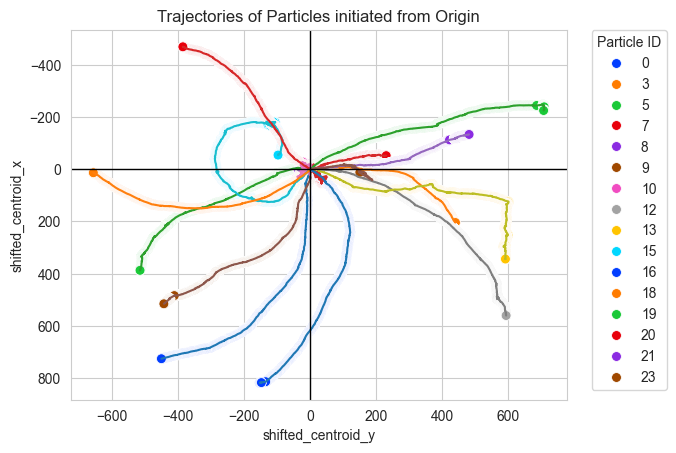

In [20]:
# Scatter plot around origin
tracker.visualize_particle_trajectories_from_origin()

3. Visualize a heatmap that illustrates the overall motility patterns covered by the biomes collectively.

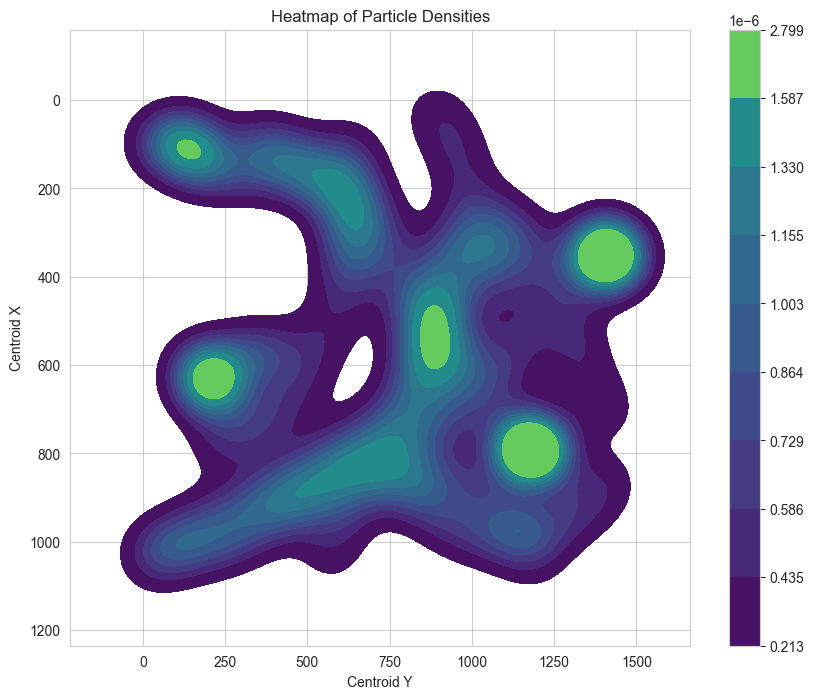

In [21]:
# Heatmap of particles
tracker.visualize_particle_heatmap()

#### Step 4: Statistics

In this step, all relevant statistics are calculated. As with previous steps, you need to supply the `tracker` object to the `Stat` class to perform the calculations. After that, we calculate the speeds, apply a normal distribution to these values, and then plot the results.

Total unique particles: 16


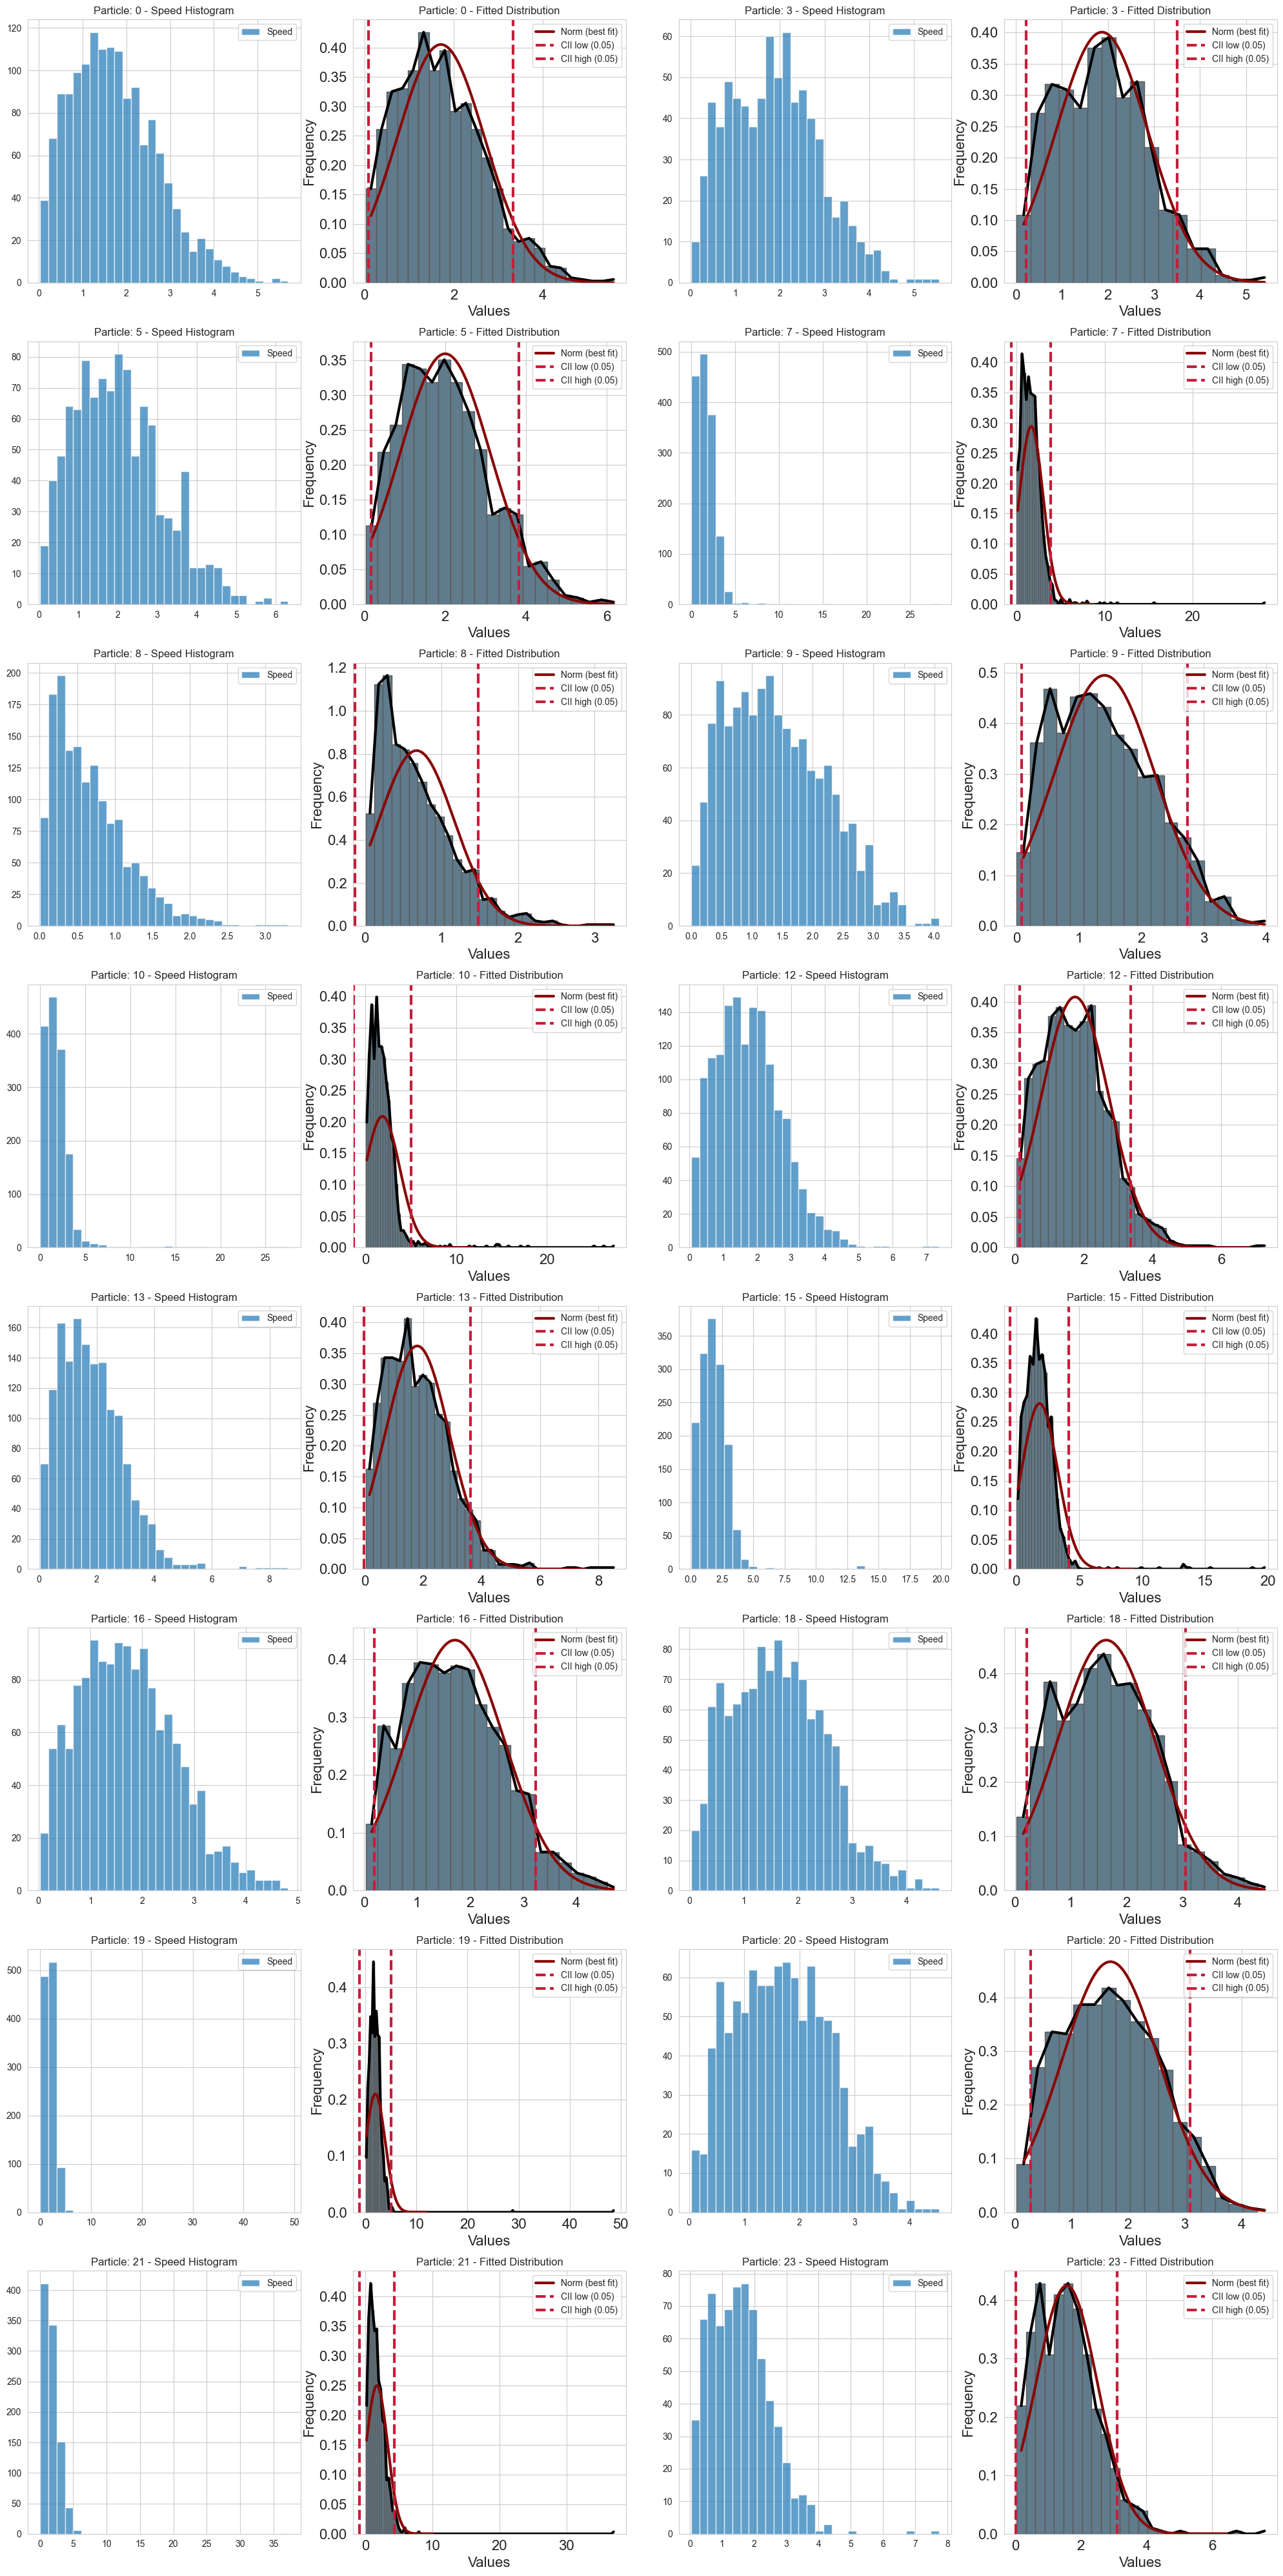

array([1.71215367, 1.87233438, 1.99968057, 1.66231087, 0.67216803,
       1.40841912, 1.87959843, 1.74957506, 1.79970268, 1.85102173,
       1.71299275, 1.6365665 , 1.94740601, 1.69030284, 1.72152052,
       1.56818788])

In [22]:
# Initialize the stats object with the tracker object
stats = Stats(tracker_object=tracker)

# Calculate the speed and plot the mean of the distribution
stats.calculate_speed_and_plot_mean(distribution_type='norm')

We can calculate the overall mean speed distribution and generate a histogram visualization to better understand the distribution of speeds. Additionally, the mean speeds can be saved to a CSV file for further analysis or record-keeping.

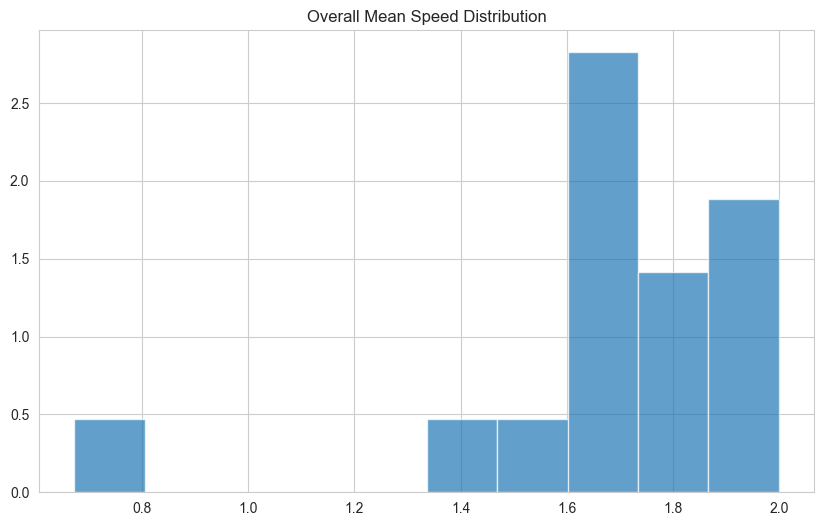

Mean speeds saved to input_files/mean_speeds.csv


In [23]:
# plot the overall mean speed distribution
stats.plot_overall_mean_speed_distribution(bins=10)

# Save the mean speeds to a CSV file
stats.save_mean_speeds(filename='mean_speeds')

Finally, we can see the mean speed of the particles in the video. This is just a simple example of how you can use the Microbe Vision package to analyze videos of microorganisms. You can further customize the analysis by changing the parameters and functions used in the package.

### Additional Notebooks for other use cases
- Combining the Linked Dataframes to get their trajectories together